# IMAT data vertical settings: peak fitting
## In this notebook I start from the spectra saved in the Imat_data_verticalSettings notebook, and apply peak fitting in selected peaks. 

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
import os, fnmatch
from os import listdir
#%matplotlib inline
%matplotlib notebook
import scipy.signal
import matplotlib.patches as patches
from skimage.filters import threshold_otsu
from scipy.stats import binned_statistic
from scipy.signal import resample

import AdvancedBraggEdgeFitting
import TOF_routines
from TOF_routines import binning
from TOF_routines import tof2l
from TOF_routines import l2tof
from TOF_routines import find_nearest

In [2]:
# here now I put the number obtained from the flight-path calibration
t0 =  0.0002466
L = 56.065
lambda0 = 0.017
dL = 0

In [44]:
# Load of computed spectra for the selected ROIs
stress_304 = np.loadtxt('spectrum_stress_304.txt')
ob_304 = np.loadtxt('spectrum_ob_stress_304.txt')
stress_316 = np.loadtxt('spectrum_stress_316.txt')
ob_316 = np.loadtxt('spectrum_ob_stress_316.txt')

# Load TOF
myTOF = np.genfromtxt('/media/carminati_c/Data2/IMAT_Nov2018/03_VerticalSetting_3hruns/Flat1_Corrected/IMAT00010433_VerticalSetting_2hruns_000_Spectra.txt', usecols=0)

In [4]:
# Load some theoretical values
mylambda = np.genfromtxt('lambda.txt',usecols=0)
myalpha = np.genfromtxt('alpha.txt',usecols=0)
mygamma = np.genfromtxt('gamma.txt',usecols=0)

dhkl_alphaFe = np.genfromtxt('alphaFe_hkl', usecols=4)
h_alphaFe= np.genfromtxt('alphaFe_hkl', usecols=0)
k_alphaFe= np.genfromtxt('alphaFe_hkl', usecols=1)
l_alphaFe= np.genfromtxt('alphaFe_hkl', usecols=2)

dhkl_gammaFe = np.genfromtxt('gammaFe_hkl', usecols=4)
h_gammaFe= np.genfromtxt('gammaFe_hkl', usecols=0)
k_gammaFe= np.genfromtxt('gammaFe_hkl', usecols=1)
l_gammaFe= np.genfromtxt('gammaFe_hkl', usecols=2)

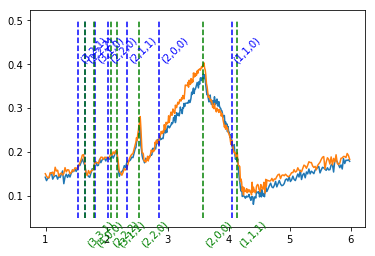

In [46]:
# Angle by angle comparison, now normalization by the last part
stress304_spectrum_norm=(stress_304[0][:]/ob_304[0][:])
last_part_304 = np.mean(stress304_spectrum_norm[1500:2000])        
stress304_spectrum_binned = TOF_routines.binning(stress304_spectrum_norm/1, 350)
stress316_spectrum_norm=(stress_316[0][:]/ob_316[0][:])
last_part_316 = np.mean(stress316_spectrum_norm[1500:2000])        
stress316_spectrum_binned = TOF_routines.binning(stress316_spectrum_norm/1, 350)
plt.plot(binning(tof2l(myTOF, lambda0,t0,L),350), -1*np.log(stress304_spectrum_binned))
plt.plot(binning(tof2l(myTOF, lambda0,t0,L),350), -1*np.log(stress316_spectrum_binned))

for i in range(0,7):
    if i==0:
        plt.plot(np.array([2*dhkl_alphaFe[i],2*dhkl_alphaFe[i]]), np.array([0.05,0.5]), '--b',label=r'$\alpha$ Fe - Martensite')
    else:
        plt.plot(np.array([2*dhkl_alphaFe[i],2*dhkl_alphaFe[i]]), np.array([0.05,0.5]), '--b')
    mytext = '('+str((h_alphaFe[i]).astype(int))+','+str(k_alphaFe[i].astype(int))+','+str(l_alphaFe[i].astype(int))+')'
    plt.text(2*dhkl_alphaFe[i],0.45, mytext, rotation=45, color='b')

for i in range(0,7):
    if i==0:
        plt.plot(np.array([2*dhkl_gammaFe[i],2*dhkl_gammaFe[i]]), np.array([0.05,0.5]), '--g', label=r'$\gamma$ Fe - Austenite')
    else:
        plt.plot(np.array([2*dhkl_gammaFe[i],2*dhkl_gammaFe[i]]), np.array([0.05,0.5]), '--g')                    

    mytext = '('+str((h_gammaFe[i]).astype(int))+','+str(k_gammaFe[i].astype(int))+','+str(l_gammaFe[i].astype(int))+')'
    plt.text(2*dhkl_gammaFe[i],0.03, mytext, rotation=45, color='g')

In [6]:
print(2*dhkl_gammaFe[:])

[4.142 3.588 2.536 2.164 2.07  1.794 1.646 1.604 1.464 1.38  1.38  1.268
 1.212 1.196 1.196 1.134 1.094 1.082 1.036 1.004 1.004 0.994 0.958 0.934
 0.934 0.896 0.876 0.87  0.87  0.846 0.846 0.828 0.828 0.822 0.802 0.788
 0.782 0.764 0.732 0.722 0.722 0.718 0.704 0.694 0.69  0.666 0.646 0.634
 0.624 0.616 0.598 0.592 0.56  0.518]


180
3.5864977700380014


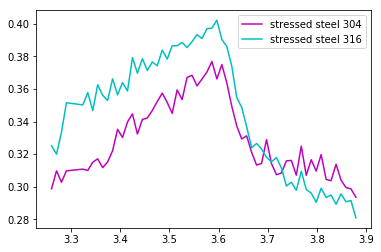

In [47]:
mylambda_binned = binning(tof2l(myTOF, lambda0,t0,L),350)
# print(np.where(3.58<mylambda_binned))
# print(np.where(3.59>mylambda_binned))
peak_position = find_nearest(mylambda_binned, 3.588)
print(peak_position)
print(mylambda_binned[180]) # this is my position to study the peak (2,0,0)

plt.plot(mylambda_binned[150:210], -1*np.log(stress304_spectrum_binned[150:210]), label='stressed steel 304', color='m') # this is possibly the range to be used for the peak fitting
plt.plot(mylambda_binned[150:210], -1*np.log(stress316_spectrum_binned[150:210]), label='stressed steel 316', color='c')
plt.legend(loc='upper right')



### known peak position for binned spectra: at position 180
### range used for peak fitting: 153-211, found with find_nearest

[153 211]
11
----- Stressed sample Steel 304 at position:  0
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 35
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00178566
    reduced chi-square = 3.5013e-05
    Akaike info crit   = -588.527775
    Bayesian info crit = -574.104674
[[Variables]]
    t0:     30.7898509 +/- 0.79654336 (2.59%) (init = 35.48039)
    sigma: -1.68376269 +/- 0.84453616 (50.16%) (init = -0.01248549)
    alpha: -0.87446675 +/- 0.97267762 (111.23%) (init = -16.4)
    a1:     0.34271510 +/- 0.00439435 (1.28%) (init = 0.3439779)
    a2:     7.3271e-04 +/- 1.2067e-04 (16.47%) (init = 0.001764948)
    a5:    -0.00275751 +/- 2.9509e-04 (10.70%) (init = -0.003759233)
    a6:     14.1030057 +/- 1.79096744 (12.70%) (init = 12.21567)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a6)       =  0.964
    C(a1, a5)       = -0.947
    C(a5, a6) 

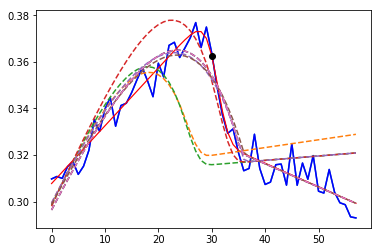

----- Stressed sample Steel 316 at position:  0
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 23
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00112321
    reduced chi-square = 2.2024e-05
    Akaike info crit   = -615.416320
    Bayesian info crit = -600.993219
[[Variables]]
    t0:     31.5289402 +/- 0.24448134 (0.78%) (init = 36.37359)
    sigma: -2.32522687 +/- 0.29419594 (12.65%) (init = -0.5796551)
    alpha: -0.38416780 +/- 47377.6046 (12332528.86%) (init = -17.02857)
    a1:     0.36505878 +/- 0.00342161 (0.94%) (init = 0.3714045)
    a2:     6.9641e-05 +/- 1.1508e-04 (165.24%) (init = 0.001267478)
    a5:    -0.00347943 +/- 2.6390e-04 (7.58%) (init = -0.00505138)
    a6:     8.97841465 +/- 1.85629360 (20.68%) (init = 9.642268)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a6)    =  0.955
    C(a5, a6)    = -0.945
    C(a1, a5)    = -0.924


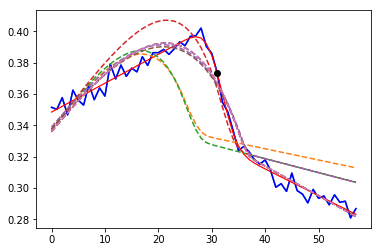

----- Stressed sample Steel 304 at position:  1
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 24
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00248585
    reduced chi-square = 4.8742e-05
    Akaike info crit   = -569.339957
    Bayesian info crit = -554.916856
[[Variables]]
    t0:     31.4267885 +/- 3.98811391 (12.69%) (init = 35)
    sigma: -1.05903754 +/- 2.26302579 (213.69%) (init = -4.429055e-08)
    alpha: -1.32755432 +/- 2.79690895 (210.68%) (init = -14.44096)
    a1:     0.69214444 +/- 0.00493650 (0.71%) (init = 0.6936881)
    a2:     7.0436e-04 +/- 1.3802e-04 (19.60%) (init = 0.0016261)
    a5:    -0.00274788 +/- 3.3336e-04 (12.13%) (init = -0.003670438)
    a6:     13.5097459 +/- 2.04773482 (15.16%) (init = 11.90825)
[[Correlations]] (unreported correlations are < 0.100)
    C(t0, alpha)    = -0.990
    C(t0, sigma)    =  0.983
    C(sigma, alpha) = -0.96

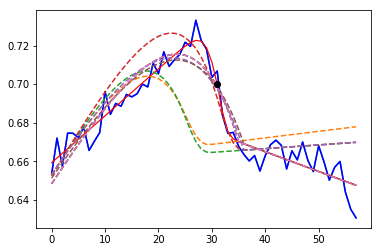

----- Stressed sample Steel 316 at position:  1
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 45
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00262706
    reduced chi-square = 5.1511e-05
    Akaike info crit   = -566.135354
    Bayesian info crit = -551.712253
[[Variables]]
    t0:     32.8755540 +/- 3.02230901 (9.19%) (init = 36.59151)
    sigma: -1.26020299 +/- 1.61542166 (128.19%) (init = -0.04738303)
    alpha: -2.09822775 +/- 2.68463796 (127.95%) (init = -18.4251)
    a1:     0.70823859 +/- 0.00490939 (0.69%) (init = 0.7111964)
    a2:     1.5348e-04 +/- 1.6121e-04 (105.04%) (init = 0.001434338)
    a5:    -0.00346031 +/- 3.8691e-04 (11.18%) (init = -0.004815103)
    a6:     10.3645427 +/- 2.49329214 (24.06%) (init = 9.445782)
[[Correlations]] (unreported correlations are < 0.100)
    C(t0, alpha)    = -0.986
    C(t0, sigma)    =  0.969
    C(a1, a6)       = 

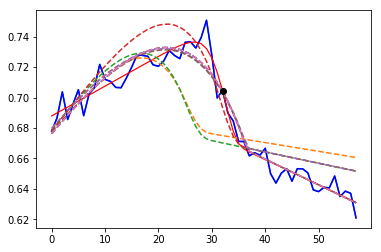

----- Stressed sample Steel 304 at position:  2
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 27
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00203748
    reduced chi-square = 3.9951e-05
    Akaike info crit   = -580.876211
    Bayesian info crit = -566.453110
[[Variables]]
    t0:     29.8591751 +/- 0.82616332 (2.77%) (init = 34.17278)
    sigma: -1.47223456 +/- 0.91703146 (62.29%) (init = -0.2141425)
    alpha: -0.70138706 +/- 1.26433862 (180.26%) (init = -13.12109)
    a1:     0.55995886 +/- 0.00392160 (0.70%) (init = 0.5597302)
    a2:     6.0608e-04 +/- 1.2297e-04 (20.29%) (init = 0.001423068)
    a5:    -0.00269587 +/- 2.8964e-04 (10.74%) (init = -0.003379177)
    a6:     15.1660185 +/- 1.76072477 (11.61%) (init = 12.91968)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a6)       =  0.943
    C(a1, a5)       = -0.939
    C(a5, a6)       = -0

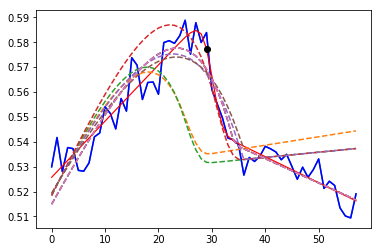

----- Stressed sample Steel 316 at position:  2
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 25
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00241312
    reduced chi-square = 4.7316e-05
    Akaike info crit   = -571.062192
    Bayesian info crit = -556.639091
[[Variables]]
    t0:     31.1307838 +/- 0.21650429 (0.70%) (init = 35.16817)
    sigma: -0.94739756 +/- 0.29055622 (30.67%) (init = -0.01736769)
    alpha: -0.14322913 +/- 460541.570 (321541823.87%) (init = -14.76316)
    a1:     0.58632439 +/- 0.00393394 (0.67%) (init = 0.5883672)
    a2:     2.0684e-04 +/- 1.2811e-04 (61.93%) (init = 0.001386361)
    a5:    -0.00309955 +/- 3.0534e-04 (9.85%) (init = -0.004281234)
    a6:     11.0268504 +/- 2.13389578 (19.35%) (init = 9.590094)
[[Correlations]] (unreported correlations are < 0.100)
    C(a5, a6)    = -0.943
    C(a1, a6)    =  0.941
    C(a1, a5)    = -0.92

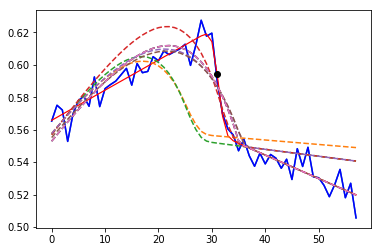

----- Stressed sample Steel 304 at position:  3
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 22
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00144178
    reduced chi-square = 2.8270e-05
    Akaike info crit   = -600.934387
    Bayesian info crit = -586.511286
[[Variables]]
    t0:     30.3322011 (init = 34.02884)
    sigma: -1.25620896 (init = -0.004302092)
    alpha: -0.15138625 (init = -12.60731)
    a1:     0.73199441 (init = 0.7331145)
    a2:     8.4633e-04 (init = 0.00174083)
    a5:    -0.00204340 (init = -0.002962156)
    a6:     10.9673546 (init = 9.718505)



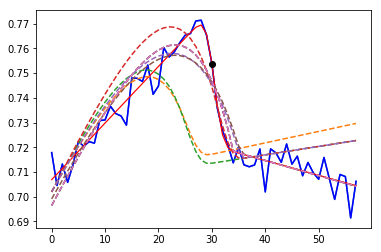

----- Stressed sample Steel 316 at position:  3
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 23
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00241874
    reduced chi-square = 4.7426e-05
    Akaike info crit   = -570.927284
    Bayesian info crit = -556.504183
[[Variables]]
    t0:     31.3730460 +/- 0.32826716 (1.05%) (init = 36.1941)
    sigma: -1.79793759 +/- 0.46684220 (25.97%) (init = -0.4357541)
    alpha: -0.37961582 +/- 269.832244 (71080.35%) (init = -17.21222)
    a1:     0.72102730 +/- 0.00650947 (0.90%) (init = 0.7237985)
    a2:     5.3276e-04 +/- 1.4690e-04 (27.57%) (init = 0.001671007)
    a5:    -0.00215625 +/- 3.5486e-04 (16.46%) (init = -0.003457177)
    a6:     5.95029884 +/- 3.52082779 (59.17%) (init = 6.771164)
[[Correlations]] (unreported correlations are < 0.100)
    C(a5, a6)       = -0.967
    C(a1, a6)       =  0.963
    C(a1, a5)       = -

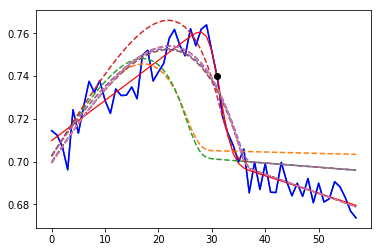

----- Stressed sample Steel 304 at position:  4
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 56
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00134490
    reduced chi-square = 2.6371e-05
    Akaike info crit   = -604.968790
    Bayesian info crit = -590.545689
[[Variables]]
    t0:     31.9998427 +/- 1.40810031 (4.40%) (init = 34)
    sigma: -0.67410475 +/- 0.87160411 (129.30%) (init = -6.399721e-07)
    alpha: -1.55367552 +/- 1.47845809 (95.16%) (init = -12.4904)
    a1:     0.54881832 +/- 0.00418829 (0.76%) (init = 0.5522166)
    a2:     5.3541e-04 +/- 1.0211e-04 (19.07%) (init = 0.001183506)
    a5:    -0.00156486 +/- 2.3774e-04 (15.19%) (init = -0.002393971)
    a6:     9.28536418 +/- 2.68442822 (28.91%) (init = 9.566549)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a6)       =  0.966
    C(t0, alpha)    = -0.963
    C(a5, a6)       = -0.941

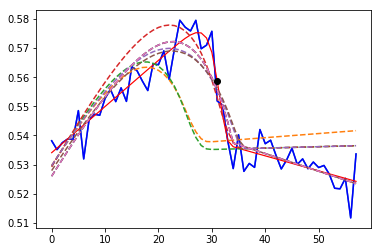

----- Stressed sample Steel 316 at position:  4
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 31
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00119573
    reduced chi-square = 2.3446e-05
    Akaike info crit   = -611.787782
    Bayesian info crit = -597.364681
[[Variables]]
    t0:     31.9250553 +/- 0.45119473 (1.41%) (init = 36.33287)
    sigma: -1.98160054 +/- 0.59672784 (30.11%) (init = -0.06339081)
    alpha: -0.80137851 +/- 1.27229979 (158.76%) (init = -17.47521)
    a1:     0.54330103 +/- 0.00561243 (1.03%) (init = 0.5497301)
    a2:     3.1915e-04 +/- 1.0522e-04 (32.97%) (init = 0.00121547)
    a5:    -0.00152091 +/- 2.6894e-04 (17.68%) (init = -0.002867114)
    a6:    -0.74996471 +/- 4.65504372 (620.70%) (init = 5.244162)
[[Correlations]] (unreported correlations are < 0.100)
    C(a5, a6)       = -0.986
    C(a1, a6)       =  0.943
    C(a1, a5)       = -

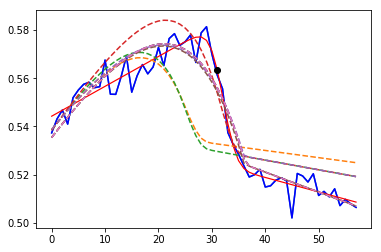

----- Stressed sample Steel 304 at position:  5
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 33
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00164006
    reduced chi-square = 3.2158e-05
    Akaike info crit   = -593.460849
    Bayesian info crit = -579.037748
[[Variables]]
    t0:     30.6845845 (init = 35.61081)
    sigma: -1.45898411 (init = -0.04331523)
    alpha: -0.06473948 (init = -16.02976)
    a1:     0.51553875 (init = 0.5152802)
    a2:     5.0332e-04 (init = 0.001210796)
    a5:    -0.00138383 (init = -0.002058713)
    a6:     8.45248988 (init = 7.337945)



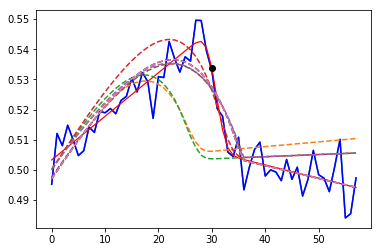

----- Stressed sample Steel 316 at position:  5
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 25
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00181256
    reduced chi-square = 3.5540e-05
    Akaike info crit   = -587.660468
    Bayesian info crit = -573.237367
[[Variables]]
    t0:     31.6797364 +/- 0.63471191 (2.00%) (init = 36.20922)
    sigma: -2.53730760 +/- 0.86143544 (33.95%) (init = -0.496966)
    alpha: -1.04869823 +/- 1.74403255 (166.30%) (init = -17.1246)
    a1:     0.51171259 +/- 0.01205132 (2.36%) (init = 0.5216575)
    a2:     4.4335e-04 +/- 1.4113e-04 (31.83%) (init = 0.001257126)
    a5:    -8.6824e-04 +/- 3.5857e-04 (41.30%) (init = -0.002217464)
    a6:    -15.1910119 +/- 11.7289048 (77.21%) (init = 0.3453702)
[[Correlations]] (unreported correlations are < 0.100)
    C(a5, a6)       = -0.991
    C(a1, a5)       = -0.948
    C(a1, a6)       =  0.

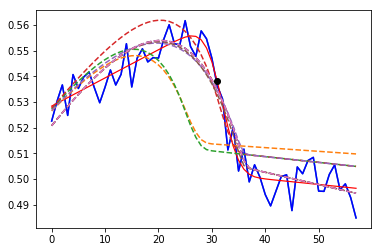

----- Stressed sample Steel 304 at position:  6
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 29
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00158845
    reduced chi-square = 3.1146e-05
    Akaike info crit   = -595.315456
    Bayesian info crit = -580.892355
[[Variables]]
    t0:     30.2670348 (init = 34.24003)
    sigma: -1.65154266 (init = -0.02494797)
    alpha: -0.11505865 (init = -11.18036)
    a1:     0.50318949 (init = 0.5039683)
    a2:     2.9998e-04 (init = 0.0007293457)
    a5:    -0.00138863 (init = -0.001830174)
    a6:     10.6310596 (init = 9.534176)



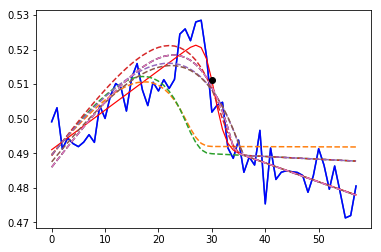

----- Stressed sample Steel 316 at position:  6
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 99
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00144918
    reduced chi-square = 2.8415e-05
    Akaike info crit   = -600.637678
    Bayesian info crit = -586.214577
[[Variables]]
    t0:     31.4832367 (init = 36.99999)
    sigma: -1.33838363 (init = -2.74148e-06)
    alpha: -0.17652524 (init = -17.51641)
    a1:     0.48840877 (init = 0.4871412)
    a2:     2.0567e-04 (init = 0.0009153353)
    a5:    -8.7980e-04 (init = -0.001644572)
    a6:    -8.79715308 (init = -1.013666)



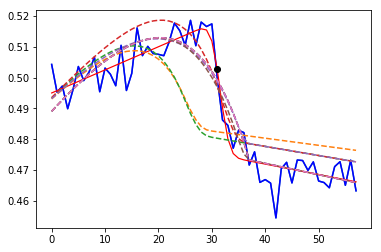

----- Stressed sample Steel 304 at position:  7
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 20
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00178090
    reduced chi-square = 3.4920e-05
    Akaike info crit   = -588.682729
    Bayesian info crit = -574.259628
[[Variables]]
    t0:     35.9999998 +/- 1.76320905 (4.90%) (init = 36)
    sigma:  8.8792e-08 +/- 5.78397308 (6514072927.13%) (init = -5.744511e-07)
    alpha: -19.0809808 +/- 14.7380297 (77.24%) (init = -19.08101)
    a1:     0.45068747 +/- 0.00579207 (1.29%) (init = 0.4506875)
    a2:     7.5855e-04 +/- 5.2643e-04 (69.40%) (init = 0.000758552)
    a5:    -0.00175912 +/- 5.8689e-04 (33.36%) (init = -0.001759123)
    a6:     10.3930182 +/- 4.33949338 (41.75%) (init = 10.39302)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a6)       =  0.961
    C(alpha, a2)    = -0.925
    C(alpha, a5)    

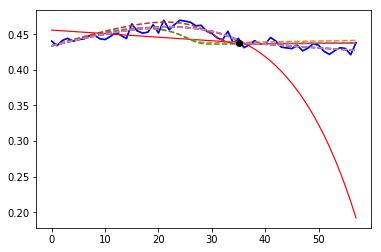

----- Stressed sample Steel 316 at position:  7
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 57
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00160146
    reduced chi-square = 3.1401e-05
    Akaike info crit   = -594.842508
    Bayesian info crit = -580.419407
[[Variables]]
    t0:     32.5886300 (init = 37.12958)
    sigma: -3.13697438 (init = -6.329718e-08)
    alpha: -0.24031568 (init = -18.53688)
    a1:     0.37343941 (init = 0.4217529)
    a2:     6.5756e-04 (init = 0.001168348)
    a5:     1.4773e-04 (init = -0.001227319)
    a6:    -65.8740855 (init = -2.86608)



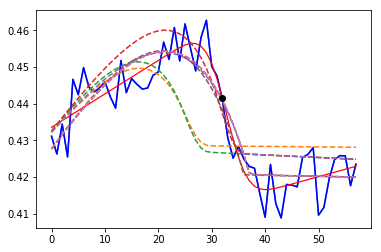

----- Stressed sample Steel 304 at position:  8
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 31
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00156118
    reduced chi-square = 3.0611e-05
    Akaike info crit   = -596.319779
    Bayesian info crit = -581.896678
[[Variables]]
    t0:     29.9085757 (init = 34.87256)
    sigma: -0.66530532 (init = -0.02579932)
    alpha: -0.06574489 (init = -14.06207)
    a1:     0.42107315 (init = 0.4183469)
    a2:     4.3796e-04 (init = 0.0009362222)
    a5:    -9.2331e-04 (init = -0.001270986)
    a6:     7.99164981 (init = 5.510838)



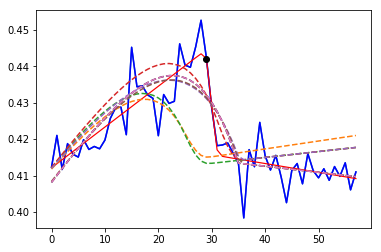

----- Stressed sample Steel 316 at position:  8
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 60
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00138867
    reduced chi-square = 2.7229e-05
    Akaike info crit   = -603.111524
    Bayesian info crit = -588.688423
[[Variables]]
    t0:     32.2153835 +/- 0.72393170 (2.25%) (init = 36.61078)
    sigma: -3.26170322 +/- 0.73850430 (22.64%) (init = -0.9771131)
    alpha: -0.50910734 +/- 481230.151 (94524300.81%) (init = -17.22308)
    a1:     0.33715242 +/- 0.09232207 (27.38%) (init = 0.4054922)
    a2:     5.6345e-04 +/- 1.5954e-04 (28.32%) (init = 0.001006333)
    a5:     2.5100e-04 +/- 3.5087e-04 (139.79%) (init = -0.0009919929)
    a6:    -118.730730 +/- 145.054029 (122.17%) (init = -6.774687)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a5)       = -0.996
    C(a1, a6)       =  0.970
    C(a5, a6) 

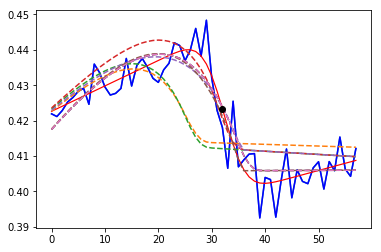

----- Stressed sample Steel 304 at position:  9
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 31
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00136208
    reduced chi-square = 2.6708e-05
    Akaike info crit   = -604.232632
    Bayesian info crit = -589.809531
[[Variables]]
    t0:     30.6976448 (init = 35.24975)
    sigma: -1.58223179 (init = -0.03332607)
    alpha: -0.12900709 (init = -14.74524)
    a1:     0.23859380 (init = 0.2422224)
    a2:     6.7503e-04 (init = 0.001161656)
    a5:    -2.8093e-04 (init = -0.0008699677)
    a6:    -4.90623946 (init = 1.1145)



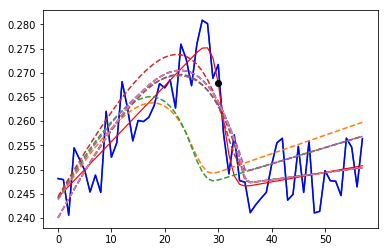

----- Stressed sample Steel 316 at position:  9
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 32
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00195918
    reduced chi-square = 3.8415e-05
    Akaike info crit   = -583.149122
    Bayesian info crit = -568.726021
[[Variables]]
    t0:     35.5172626 +/- 2530.97991 (7126.06%) (init = 36.08065)
    sigma: -0.01775557 +/- 776862.007 (4375315155.48%) (init = -0.01571628)
    alpha: -5.45018261 +/- 2.39495828 (43.94%) (init = -16.66659)
    a1:     0.20342548 +/- 0.04189158 (20.59%) (init = 0.2334738)
    a2:     6.9171e-04 +/- 1.8397e-04 (26.60%) (init = 0.00113626)
    a5:     1.6998e-04 +/- 3.4615e-04 (203.64%) (init = -0.0006271306)
    a6:    -55.5105663 +/- 54.7749607 (98.67%) (init = -10.4581)
[[Correlations]] (unreported correlations are < 0.100)
    C(t0, sigma)    = -1.000
    C(a1, a5)       = -0.996
    C(a5, a

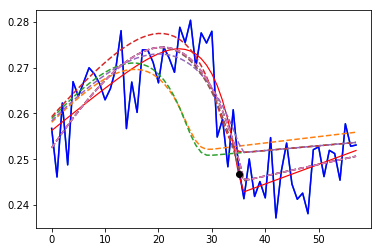

----- Stressed sample Steel 304 at position:  10
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 26
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00120700
    reduced chi-square = 2.3667e-05
    Akaike info crit   = -611.243379
    Bayesian info crit = -596.820278
[[Variables]]
    t0:     31.0900947 (init = 35.56561)
    sigma: -1.88070292 (init = -0.543759)
    alpha: -0.16260783 (init = -14.17691)
    a1:     0.42174195 (init = 0.4273564)
    a2:     6.3997e-04 (init = 0.001027019)
    a5:    -3.1869e-04 (init = -0.0009059549)
    a6:    -3.02359793 (init = 3.294758)



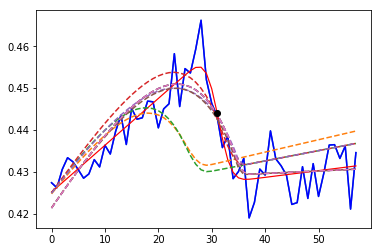

----- Stressed sample Steel 316 at position:  10
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 68
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00144670
    reduced chi-square = 2.8367e-05
    Akaike info crit   = -600.736795
    Bayesian info crit = -586.313694
[[Variables]]
    t0:     34.9999995 (init = 36)
    sigma: -5.5487e-09 (init = -5.935351e-09)
    alpha: -3.89059428 (init = -17.00606)
    a1:     0.43752315 (init = 0.4466774)
    a2:     4.0478e-04 (init = 0.0008637981)
    a5:    -2.8249e-04 (init = -0.001042886)
    a6:    -21.9028027 (init = -2.023453)



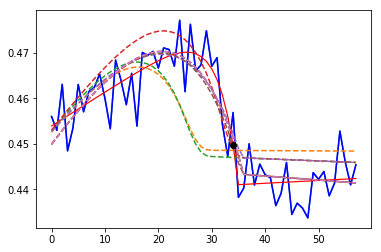

In [62]:
# I start with the position at 90 deg to see if everything works.

est_sigma=-1
est_alpha=-10

lambda_range = [3.3, 3.9]
myrange = np.array([find_nearest(mylambda_binned, lambda_range[0]), find_nearest(mylambda_binned, lambda_range[1])])
print(myrange)

print(len(stress_304))

results_stress_304 = [dict() for x in range(len(stress_304))]
results_stress_316 = [dict() for x in range(len(stress_304))]

for i in range(0, len(stress_304)):
    stress304_spectrum_norm=(stress_304[i][:]/ob_304[i][:])
    stress304_spectrum_binned = binning(stress304_spectrum_norm, 350)
    stress316_spectrum_norm=(stress_316[i][:]/ob_316[i][:])
    stress316_spectrum_binned = binning(stress316_spectrum_norm, 350)
    
    print('----- Stressed sample Steel 304 at position: ', i)
    
    results_stress_304[i] = AdvancedBraggEdgeFitting.AdvancedBraggEdgeFitting(-1*np.log(stress304_spectrum_binned), myrange, peak_position, est_sigma, est_alpha, False)
    
    print('----- Stressed sample Steel 316 at position: ', i)
    results_stress_316[i] = AdvancedBraggEdgeFitting.AdvancedBraggEdgeFitting(-1*np.log(stress316_spectrum_binned), myrange, peak_position, est_sigma, est_alpha, False)
    


#     results_stress1 = AdvancedBraggEdgeFitting.AdvancedBraggEdgeFitting(-1*np.log(stress1_spectrum_binned), myrange, peak_position, est_sigma, est_alpha, False)
#     results_stress2 = AdvancedBraggEdgeFitting.AdvancedBraggEdgeFitting(-1*np.log(stress2_spectrum_binned), myrange, peak_position, est_sigma, est_alpha, False)


[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 20
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00178090
    reduced chi-square = 3.4920e-05
    Akaike info crit   = -588.682729
    Bayesian info crit = -574.259628
[[Variables]]
    t0:     35.9999998 +/- 1.76320905 (4.90%) (init = 36)
    sigma:  8.8792e-08 +/- 5.78397308 (6514072927.13%) (init = -5.744511e-07)
    alpha: -19.0809808 +/- 14.7380297 (77.24%) (init = -19.08101)
    a1:     0.45068747 +/- 0.00579207 (1.29%) (init = 0.4506875)
    a2:     7.5855e-04 +/- 5.2643e-04 (69.40%) (init = 0.000758552)
    a5:    -0.00175912 +/- 5.8689e-04 (33.36%) (init = -0.001759123)
    a6:     10.3930182 +/- 4.33949338 (41.75%) (init = 10.39302)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a6)       =  0.961
    C(alpha, a2)    = -0.925
    C(alpha, a5)    =  0.855
    C(a2, a5)       = -0.712
    C(t0, 

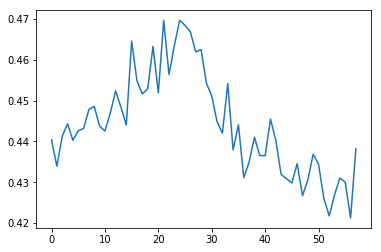

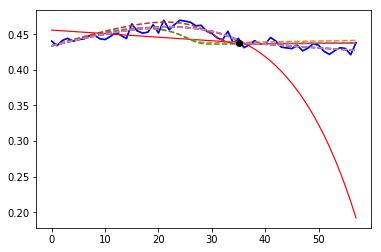

{'t0': 35.99999976232655,
 'sigma': 8.879196086027165e-08,
 'alpha': -19.080980796005615,
 'a1': 0.45068747298192047,
 'a2': 0.0007585510178642903,
 'a5': -0.0017591218831422284,
 'a6': 10.393018181651167,
 'final_result': <lmfit.model.ModelResult at 0x7f5bd8a5c0f0>}

In [73]:
stress304_spectrum_norm=(stress_304[7][:]/ob_304[7][:])
stress304_spectrum_binned = binning(stress304_spectrum_norm, 350)
plt.figure()
plt.plot(-1*np.log(stress304_spectrum_binned[myrange[0]:myrange[1]]))
plt.figure()
AdvancedBraggEdgeFitting.AdvancedBraggEdgeFitting(-1*np.log(stress304_spectrum_binned), myrange, peak_position, est_sigma, est_alpha, False)

30.789850931377643
3.616846298135999
31.52894021522026
3.6269577700644864


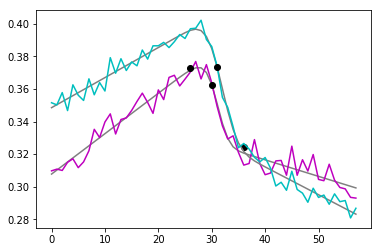

In [41]:
results_s1 = results_stress1['final_result']
fit_stress1=results_s1.best_fit
t0_stress1 = results_stress1['t0']
sigma_stress1 = results_stress1['sigma']
plt.plot(fit_stress1, color='gray')
plt.plot(-1*np.log(stress1_spectrum_binned[myrange[0]:myrange[1]]), color='m')
plt.plot(int(t0_stress1),fit_stress1[int(t0_stress1)],'ok')
plt.plot(round(t0_stress1+3*sigma_stress1), fit_stress1[int(t0_stress1+2*sigma_stress1)], 'ok')
plt.plot(round(t0_stress1-3*sigma_stress1), fit_stress1[int(t0_stress1-2*sigma_stress1)], 'ok')

results_s2 = results_stress2['final_result']
fit_stress2=results_s2.best_fit
t0_stress2 = results_stress2['t0']
sigma_stress2 = results_stress2['sigma']
plt.plot(fit_stress2, color='gray')
plt.plot(-1*np.log(stress2_spectrum_binned[myrange[0]:myrange[1]]), color='c')
plt.plot(int(t0_stress2),fit_stress2[int(t0_stress2)],'ok')
# plt.plot(t0_stress2+3*sigma_stress1, fit_stress1[int(t0_stress1+2*sigma_stress1)], 'ok')
# plt.plot(t0_stress1-3*sigma_stress1, fit_stress1[int(t0_stress1-2*sigma_stress1)], 'ok')

print(t0_stress1)
print(mylambda_binned[myrange[0]+int(t0_stress1)])
print(t0_stress2)
print(mylambda_binned[myrange[0]+int(t0_stress2)])